## Data Cleaning

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", None)

In [6]:
# define column names as defined by the NASA instructions

def load_cmapss_data(train_path, test_path, rul_path):

    # apply the unit number and the time (in cycles)
    index_names = ['unit_number', 'time_cycles']

    # there are three operational settings that are utilized by the engine
    setting_names = ['setting_1', 'setting_2', 'setting_3']

    # add sensor numbers to the sensors
    sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]

    # join the index, setting and sensor column names to then apply to the txt files
    col_names = index_names + setting_names + sensor_names

    # read txt data and apply the above
    train = pd.read_csv(train_path, sep='\s+', header=None, names=col_names)
    test = pd.read_csv(test_path, sep='\s+', header=None, names=col_names)
    y_test = pd.read_csv(rul_path, sep='\s+', header=None, names=['RUL'])

    return train, test, y_test

In [7]:
def load_cmapss_data(train_path, test_path, rul_path, include_sensor_desc = True):

    # sensor column descriptions
    description_headers = ["Temp, fan in", "Temp, LPC out", "Temp, HPC out", 
                           "Temp, LPT out", "Press, fan in", "Tot Press, bypass", "Tot Press, HPC out",
                           "Speed, fan", "Speed, core", "Eng Press Ratio", "Stat Press, HPC out", 
                           "phi Fuel Flow Ratio", "Corr. Speed, Fan", "Corr. Speed, Core", "Bypass Ratio", 
                           "Burner Fuel/Air Ratio", "Bleed Enthalpy", "Dem Speed, fan", "Dem Corr Speed, fan", 
                           "Coolant Bleed, HPT", "Coolant Bleed, LPT" ]
    
    # apply the unit number and the time (in cycles)
    index_names = ['unit_number', 'time_cycles']
    
    # there are three operational settings that are utilized by the engine 
    setting_names = ['setting_1', 'setting_2', 'setting_3']

    # add sensor numbers to the sensors
    sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
    
    # join the index, setting and sensor column names to then apply to the txt files
    if include_sensor_desc == False:
        col_names = index_names + setting_names + sensor_names
    else:
        col_names = index_names + setting_names + description_headers
    
    # read txt data and apply the above 
    train = pd.read_csv(train_path, sep='\s+', header=None, names=col_names)
    test = pd.read_csv(test_path, sep='\s+', header=None, names=col_names)
    y_test = pd.read_csv(rul_path, sep='\s+', header=None, names=['RUL'])
    
    return train, test, y_test

In [8]:
# Data Set: FD001
# Train trjectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: ONE (HPC Degradation)

# reading in the first dataset since it is a dataset that has one condition and one fault, and will allow us to make a relatively easier model
# that can then be built upon in complexity in the second stage of the analysis

train, test, y_test = load_cmapss_data('../data/CMAPSSData/train_FD001.txt', '../data/CMAPSSData/test_FD001.txt', '../data/CMAPSSData/RUL_FD001.txt')

In [9]:
original_cols = train.columns
original_cols

Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       'Temp, fan in', 'Temp, LPC out', 'Temp, HPC out', 'Temp, LPT out',
       'Press, fan in', 'Tot Press, bypass', 'Tot Press, HPC out',
       'Speed, fan', 'Speed, core', 'Eng Press Ratio', 'Stat Press, HPC out',
       'phi Fuel Flow Ratio', 'Corr. Speed, Fan', 'Corr. Speed, Core',
       'Bypass Ratio', 'Burner Fuel/Air Ratio', 'Bleed Enthalpy',
       'Dem Speed, fan', 'Dem Corr Speed, fan', 'Coolant Bleed, HPT',
       'Coolant Bleed, LPT'],
      dtype='object')

In [10]:
train.head()

unit_number  time_cycles  setting_1  setting_2  setting_3  Temp, fan in  \
0            1            1    -0.0007    -0.0004      100.0        518.67   
1            1            2     0.0019    -0.0003      100.0        518.67   
2            1            3    -0.0043     0.0003      100.0        518.67   
3            1            4     0.0007     0.0000      100.0        518.67   
4            1            5    -0.0019    -0.0002      100.0        518.67   

   Temp, LPC out  Temp, HPC out  Temp, LPT out  Press, fan in  ...  \
0         641.82        1589.70        1400.60          14.62  ...   
1         642.15        1591.82        1403.14          14.62  ...   
2         642.35        1587.99        1404.20          14.62  ...   
3         642.35        1582.79        1401.87          14.62  ...   
4         642.37        1582.85        1406.22          14.62  ...   

   phi Fuel Flow Ratio  Corr. Speed, Fan  Corr. Speed, Core  Bypass Ratio  \
0               521.66           2388.02            8138.62        8.4195   
1               522.28           2388.07            8131.49        8.4318   
2               522.42           2388.03            8133.23        8.4178   
3               522.86           2388.08            8133.83        8.3682   
4               522.19           2388.04            8133.80        8.4294   

   Burner Fuel/Air Ratio  Bleed Enthalpy  Dem Speed, fan  Dem Corr Speed, fan  \
0                   0.03             392            2388                100.0   
1                   0.03             392            2388                100.0   
2                   0.03             390            2388                100.0   
3                   0.03             392            2388                100.0   
4                   0.03             393            2388                100.0   

   Coolant Bleed, HPT  Coolant Bleed, LPT  
0               39.06             23.4190  
1               39.00             23.4236  
2               38.95             23.3442  
3               38.88             23.3739  
4               38.90             23.4044  

[5 rows x 26 columns]

In [11]:
# to get the number of unique engines in the dataset we can look at the number of unique numbers in the first column
len(np.unique(train["unit_number"]))

100

In [12]:
# the number of cycles it took for each of these engines to fail
num_cycles_to_failure = train.groupby("unit_number")["time_cycles"].count()
num_cycles_to_failure.values

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200], dtype=int64)

In [13]:
train.describe()

unit_number   time_cycles     setting_1     setting_2  setting_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000    20631.0   
mean      51.506568    108.807862     -0.000009      0.000002      100.0   
std       29.227633     68.880990      0.002187      0.000293        0.0   
min        1.000000      1.000000     -0.008700     -0.000600      100.0   
25%       26.000000     52.000000     -0.001500     -0.000200      100.0   
50%       52.000000    104.000000      0.000000      0.000000      100.0   
75%       77.000000    156.000000      0.001500      0.000300      100.0   
max      100.000000    362.000000      0.008700      0.000600      100.0   

       Temp, fan in  Temp, LPC out  Temp, HPC out  Temp, LPT out  \
count      20631.00   20631.000000   20631.000000   20631.000000   
mean         518.67     642.680934    1590.523119    1408.933782   
std            0.00       0.500053       6.131150       9.000605   
min          518.67     641.210000    1571.040000    1382.250000   
25%          518.67     642.325000    1586.260000    1402.360000   
50%          518.67     642.640000    1590.100000    1408.040000   
75%          518.67     643.000000    1594.380000    1414.555000   
max          518.67     644.530000    1616.910000    1441.490000   

       Press, fan in  ...  phi Fuel Flow Ratio  Corr. Speed, Fan  \
count   2.063100e+04  ...         20631.000000      20631.000000   
mean    1.462000e+01  ...           521.413470       2388.096152   
std     1.776400e-15  ...             0.737553          0.071919   
min     1.462000e+01  ...           518.690000       2387.880000   
25%     1.462000e+01  ...           520.960000       2388.040000   
50%     1.462000e+01  ...           521.480000       2388.090000   
75%     1.462000e+01  ...           521.950000       2388.140000   
max     1.462000e+01  ...           523.380000       2388.560000   

       Corr. Speed, Core  Bypass Ratio  Burner Fuel/Air Ratio  Bleed Enthalpy  \
count       20631.000000  20631.000000           2.063100e+04    20631.000000   
mean         8143.752722      8.442146           3.000000e-02      393.210654   
std            19.076176      0.037505           1.387812e-17        1.548763   
min          8099.940000      8.324900           3.000000e-02      388.000000   
25%          8133.245000      8.414900           3.000000e-02      392.000000   
50%          8140.540000      8.438900           3.000000e-02      393.000000   
75%          8148.310000      8.465600           3.000000e-02      394.000000   
max          8293.720000      8.584800           3.000000e-02      400.000000   

       Dem Speed, fan  Dem Corr Speed, fan  Coolant Bleed, HPT  \
count         20631.0              20631.0        20631.000000   
mean           2388.0                100.0           38.816271   
std               0.0                  0.0            0.180746   
min            2388.0                100.0           38.140000   
25%            2388.0                100.0           38.700000   
50%            2388.0                100.0           38.830000   
75%            2388.0                100.0           38.950000   
max            2388.0                100.0           39.430000   

       Coolant Bleed, LPT  
count        20631.000000  
mean            23.289705  
std              0.108251  
min             22.894200  
25%             23.221800  
50%             23.297900  
75%             23.366800  
max             23.618400  

[8 rows x 26 columns]

In [14]:
def drop_constant_value(df):
    # identify the columns where the value is constant throughout (hence obsolete)
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]

    # drop them
    return df.drop(columns=constant_columns)

# drop them in the train
train = drop_constant_value(train)

# check the shape of the train dataset
train.shape


(20631, 19)

In [15]:
def add_remaining_useful_life(df):
    # get the max cycle for each unit (100 units)
    max_cycle = df.groupby("unit_number")["time_cycles"].transform('max')

    # compute the RUL for each unit row by row till it hits 0
    df["RUL"] = max_cycle - df["time_cycles"]

    return df

# apply function
train = add_remaining_useful_life(train)

train.tail()

unit_number  time_cycles  setting_1  setting_2  Temp, LPC out  \
20626          100          196    -0.0004    -0.0003         643.49   
20627          100          197    -0.0016    -0.0005         643.54   
20628          100          198     0.0004     0.0000         643.42   
20629          100          199    -0.0011     0.0003         643.23   
20630          100          200    -0.0032    -0.0005         643.85   

       Temp, HPC out  Temp, LPT out  Tot Press, bypass  Tot Press, HPC out  \
20626        1597.98        1428.63              21.61              551.43   
20627        1604.50        1433.58              21.61              550.86   
20628        1602.46        1428.18              21.61              550.94   
20629        1605.26        1426.53              21.61              550.68   
20630        1600.38        1432.14              21.61              550.79   

       Speed, fan  Speed, core  Stat Press, HPC out  phi Fuel Flow Ratio  \
20626     2388.19      9065.52                48.07               519.49   
20627     2388.23      9065.11                48.04               519.68   
20628     2388.24      9065.90                48.09               520.01   
20629     2388.25      9073.72                48.39               519.67   
20630     2388.26      9061.48                48.20               519.30   

       Corr. Speed, Fan  Corr. Speed, Core  Bypass Ratio  Bleed Enthalpy  \
20626           2388.26            8137.60        8.4956             397   
20627           2388.22            8136.50        8.5139             395   
20628           2388.24            8141.05        8.5646             398   
20629           2388.23            8139.29        8.5389             395   
20630           2388.26            8137.33        8.5036             396   

       Coolant Bleed, HPT  Coolant Bleed, LPT  RUL  
20626               38.49             22.9735    4  
20627               38.30             23.1594    3  
20628               38.44             22.9333    2  
20629               38.29             23.0640    1  
20630               38.37             23.0522    0

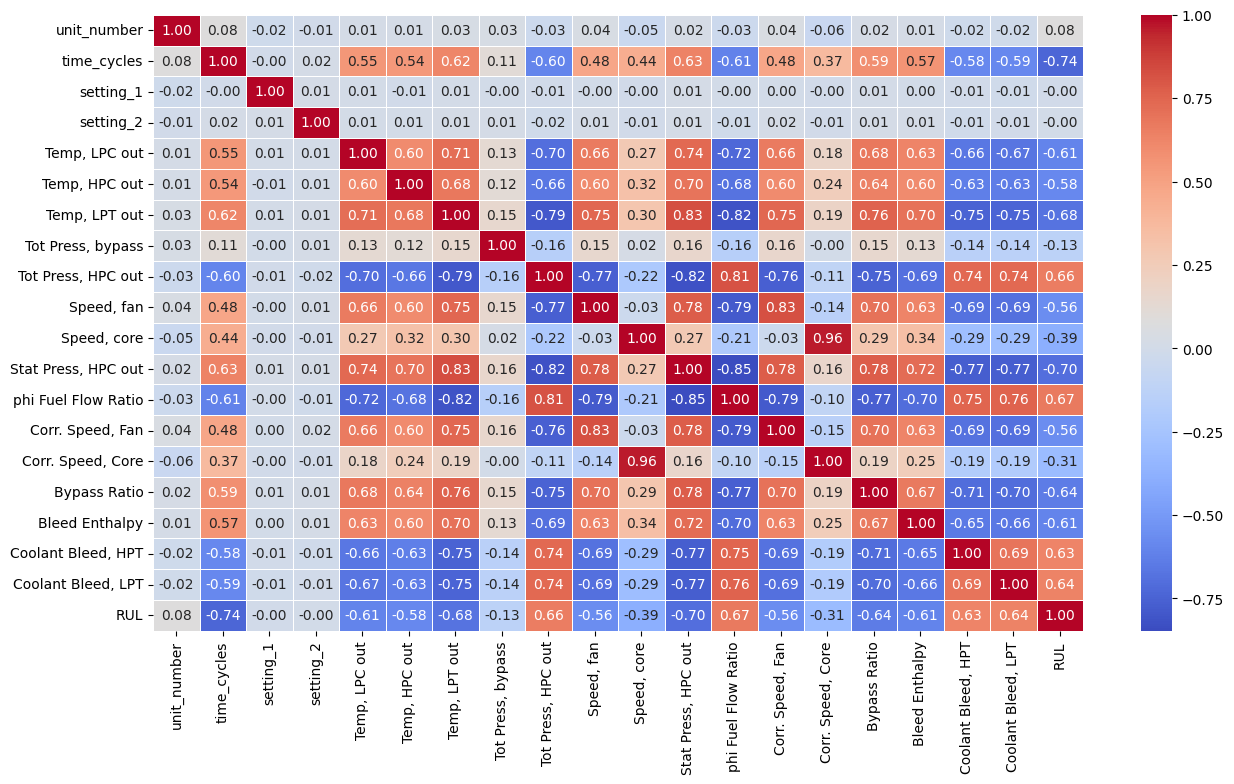

In [16]:
# make corr matrix
corr_matrix = train.corr()

# plot heatmap for corr matrix
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.show()



In [17]:
def drop_highly_correlated_features(df, threshold=0.95):

    # get the absolute corr matrix
    corr_matrix = df.corr().abs()

    # iterate through each col and find the one with the highest correlations
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[i]
                to_drop.add(colname)

    # drop the col that has highest correlations
    df = df.drop(columns=to_drop)

    print(to_drop)

    return df

# call function
train = drop_highly_correlated_features(train)


{'Corr. Speed, Core'}


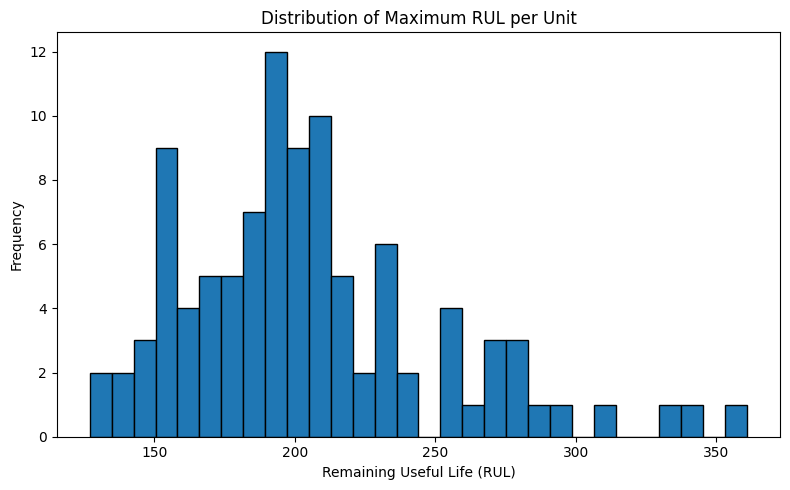

In [18]:
# get the maximum RUL for each unit
df_max_rul = train.groupby('unit_number')['RUL'].max().reset_index()

# plot historgram
plt.figure(figsize=(8, 5))
plt.hist(df_max_rul['RUL'], bins=30, edgecolor='black')

# labels and title
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum RUL per Unit')

plt.tight_layout()
plt.show()


In [19]:
train.head()

unit_number  time_cycles  setting_1  setting_2  Temp, LPC out  \
0            1            1    -0.0007    -0.0004         641.82   
1            1            2     0.0019    -0.0003         642.15   
2            1            3    -0.0043     0.0003         642.35   
3            1            4     0.0007     0.0000         642.35   
4            1            5    -0.0019    -0.0002         642.37   

   Temp, HPC out  Temp, LPT out  Tot Press, bypass  Tot Press, HPC out  \
0        1589.70        1400.60              21.61              554.36   
1        1591.82        1403.14              21.61              553.75   
2        1587.99        1404.20              21.61              554.26   
3        1582.79        1401.87              21.61              554.45   
4        1582.85        1406.22              21.61              554.00   

   Speed, fan  Speed, core  Stat Press, HPC out  phi Fuel Flow Ratio  \
0     2388.06      9046.19                47.47               521.66   
1     2388.04      9044.07                47.49               522.28   
2     2388.08      9052.94                47.27               522.42   
3     2388.11      9049.48                47.13               522.86   
4     2388.06      9055.15                47.28               522.19   

   Corr. Speed, Fan  Bypass Ratio  Bleed Enthalpy  Coolant Bleed, HPT  \
0           2388.02        8.4195             392               39.06   
1           2388.07        8.4318             392               39.00   
2           2388.03        8.4178             390               38.95   
3           2388.08        8.3682             392               38.88   
4           2388.04        8.4294             393               38.90   

   Coolant Bleed, LPT  RUL  
0             23.4190  191  
1             23.4236  190  
2             23.3442  189  
3             23.3739  188  
4             23.4044  187

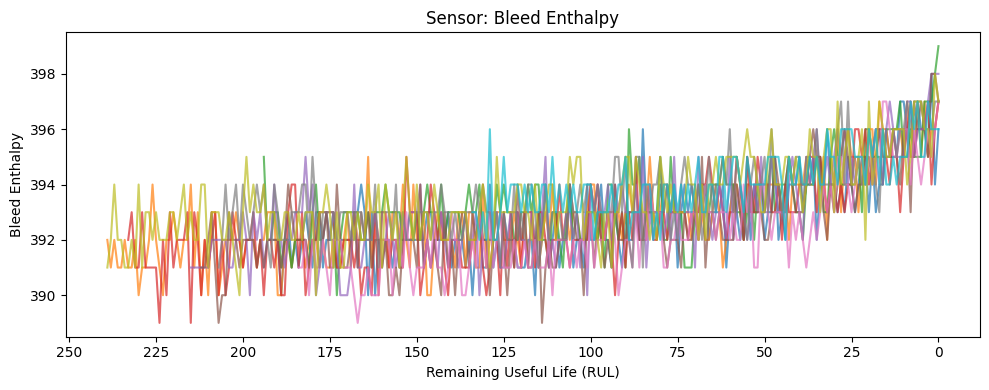

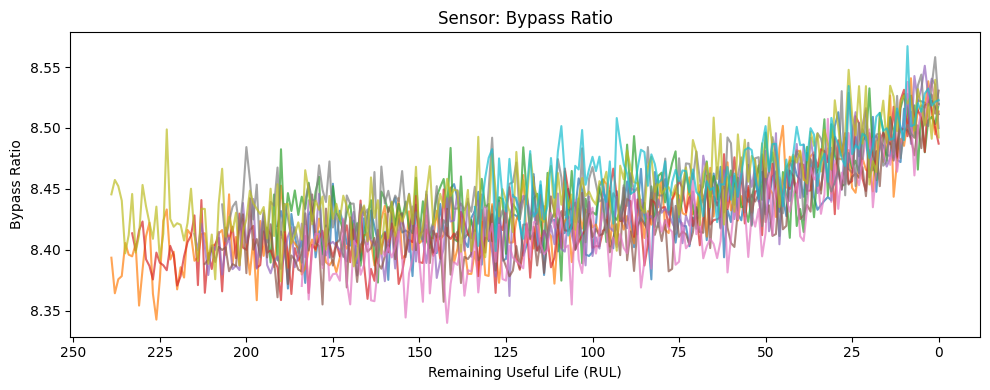

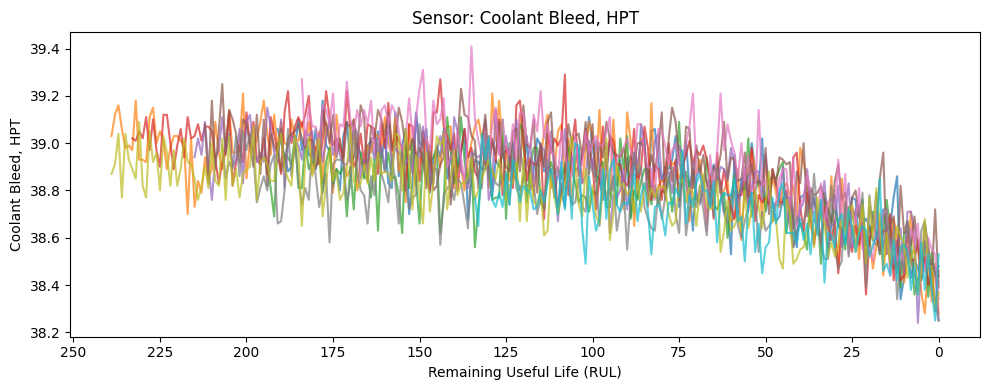

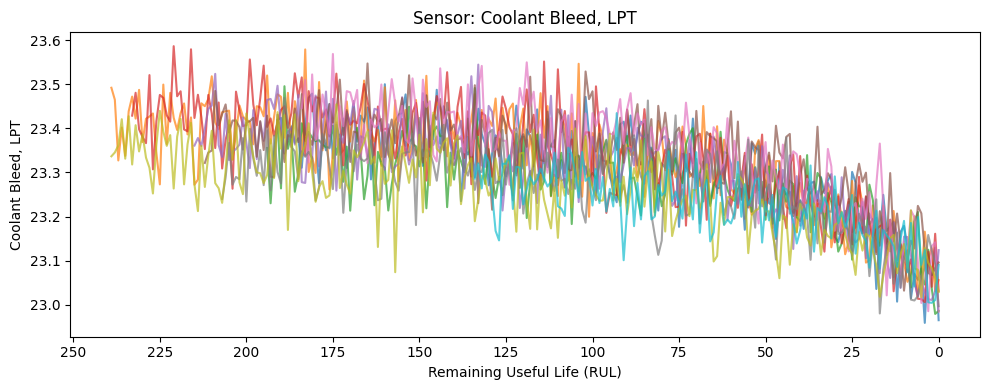

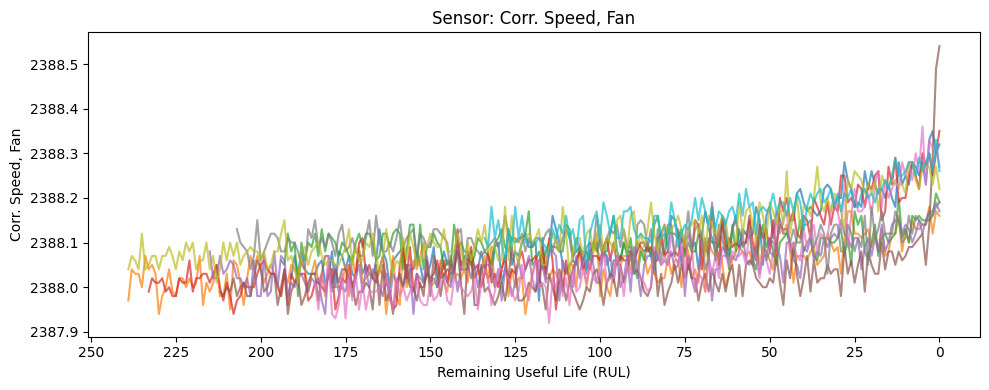

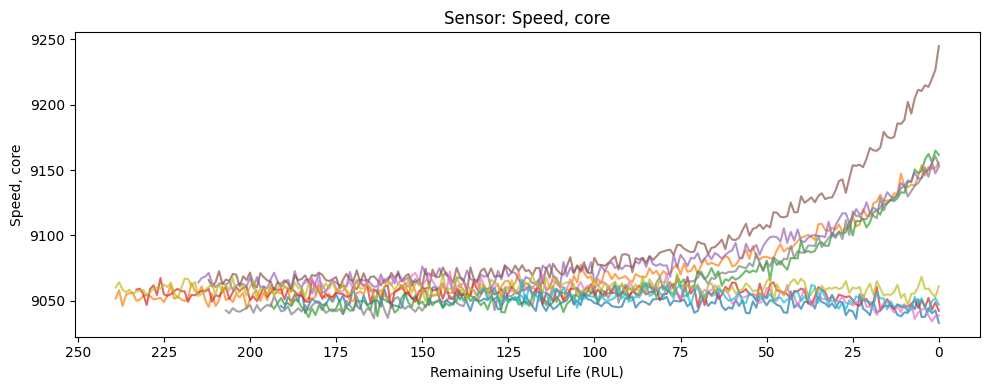

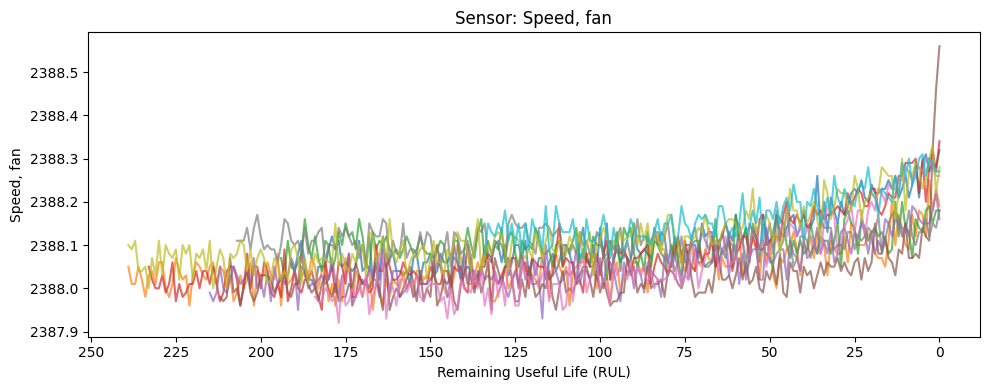

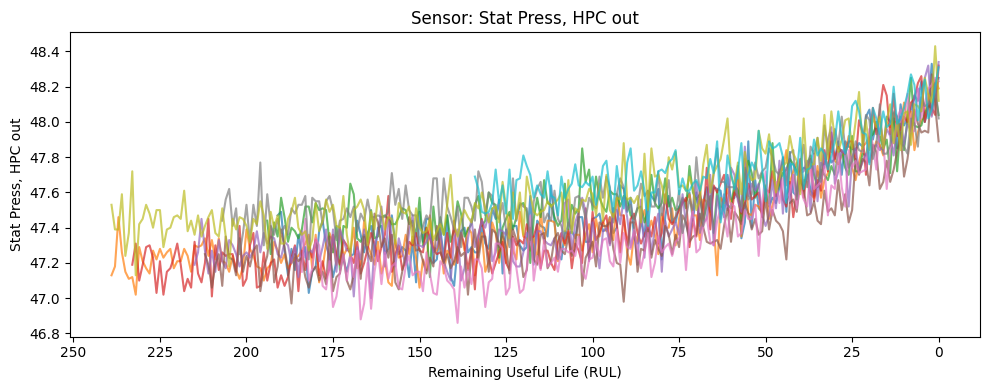

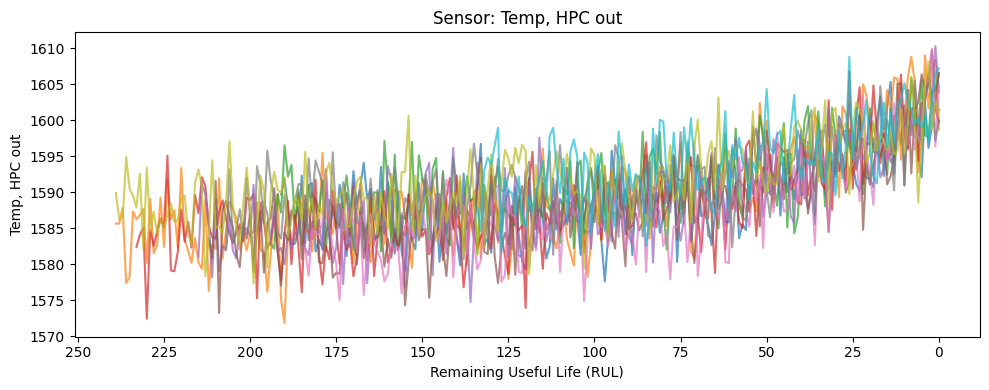

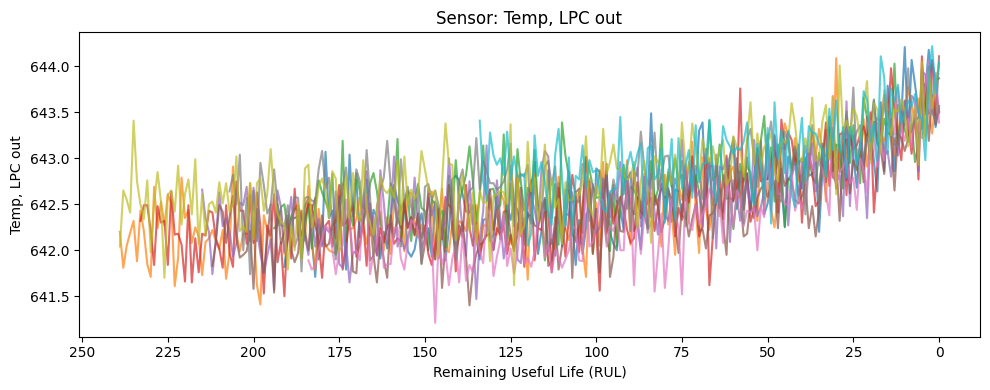

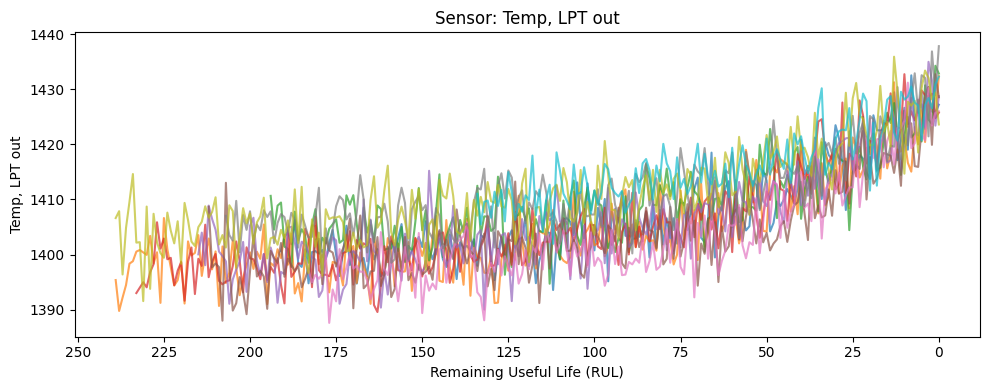

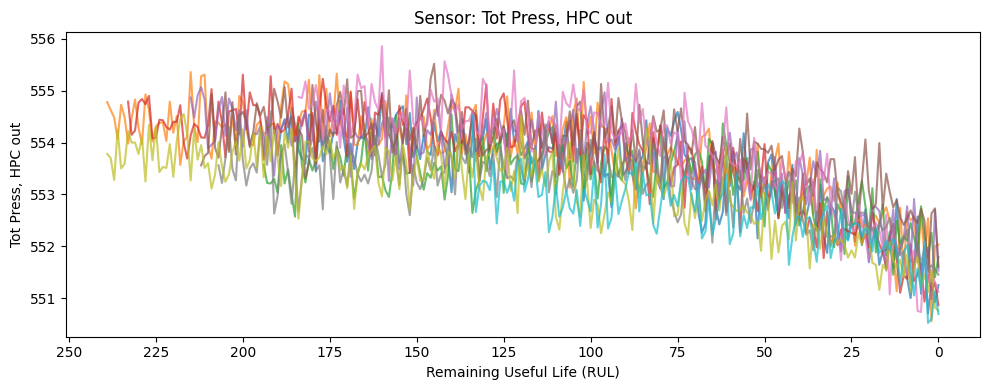

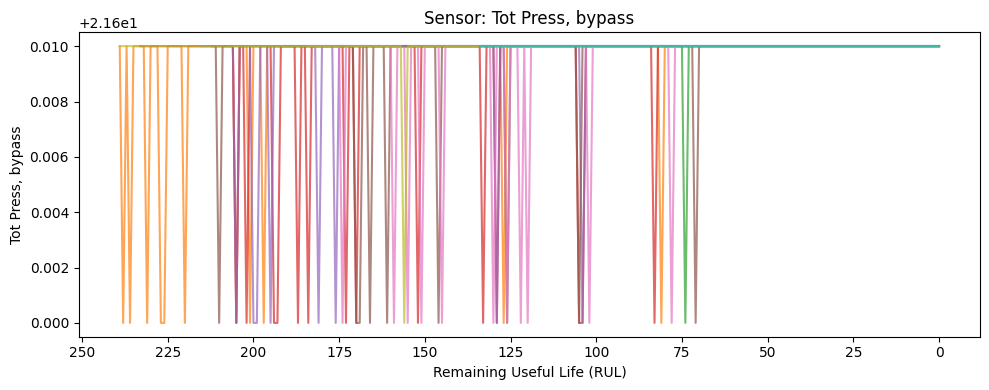

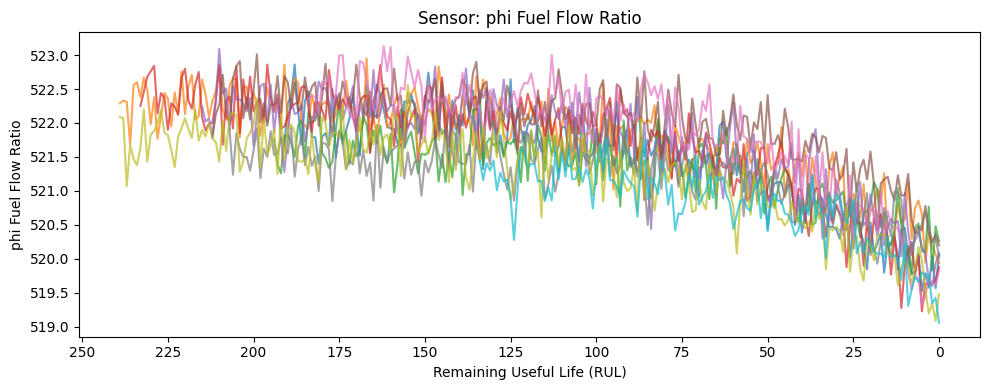

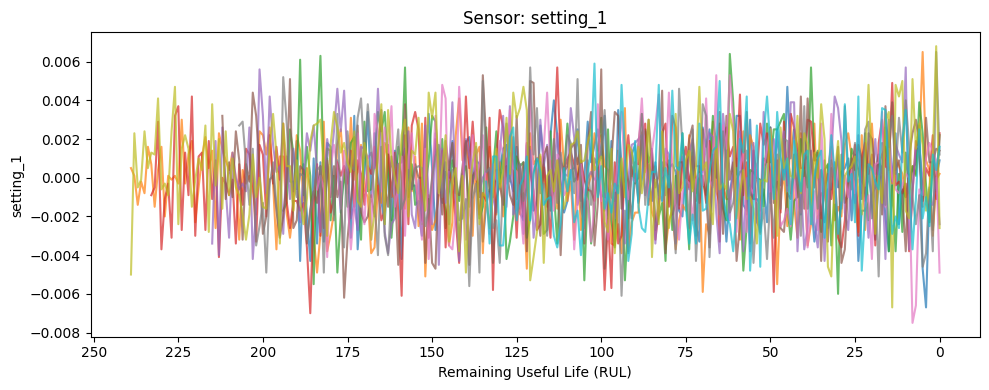

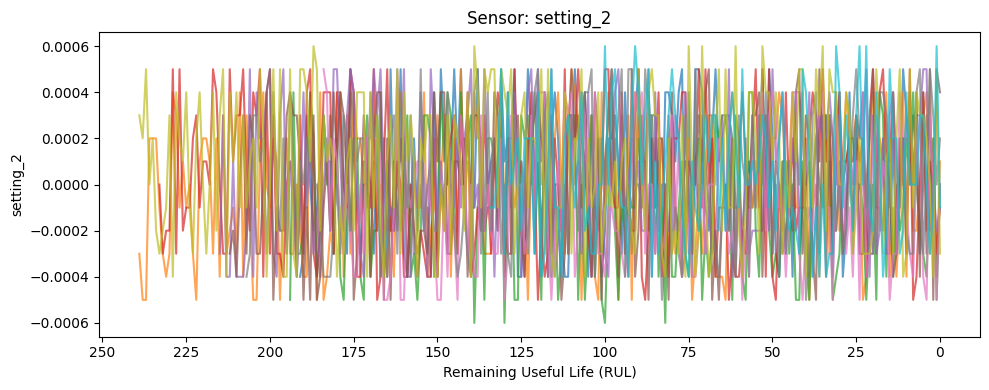

In [20]:
# plot the sensors individually against the RUL
def plot_sensors(train, step=10):

    # find the sensor cols all which have a number in them and excluse unit_number and rul
    sensor_cols = train.columns.difference(['unit_number', 'RUL', 'time_cycles'])

    for sensor in sensor_cols:
        plt.figure(figsize=(10, 4))

        # plot for every nth unit (10th, 20th, 30th ... etc)
        for unit in train['unit_number'].unique()[::step]:
            plt.plot(train[train['unit_number'] == unit]['RUL'],
                     train[train['unit_number'] == unit][sensor],
                     label=f'Unit {unit}', alpha=0.7)

        plt.gca().invert_xaxis()  # reverse the x axis so that RUL is decreasing
        plt.xticks(np.arange(0, 275, 25))
        plt.ylabel(sensor)
        plt.xlabel('Remaining Useful Life (RUL)')
        plt.title(f'Sensor: {sensor}')
        plt.tight_layout()
        plt.show()

# Call the function to plot all sensors
plot_sensors(train)


In [21]:
# we see that there are some settings/sensors that do not have much patterns when mapped against RUL. let's find them.

def drop_low_correlation_features(df, target_column='RUL', threshold=0.1, exclude_columns=None):

    # exclude specified columns
    if exclude_columns is None:
        exclude_columns = []

    # get corr matrix
    corr_matrix = df.drop(columns=exclude_columns).corr()

    # get corr matrix against target col
    correlations = corr_matrix[target_column]

    # get features with correlations lower than the threshold
    low_correlation_features = correlations[correlations.abs() < threshold].index.tolist()

    # drop those with less than the threshold correlations
    df = df.drop(columns=low_correlation_features)

    return df

train = drop_low_correlation_features(train, threshold=0.1, exclude_columns=['unit_number', 'time_cycles'])

train.head()

unit_number  time_cycles  Temp, LPC out  Temp, HPC out  Temp, LPT out  \
0            1            1         641.82        1589.70        1400.60   
1            1            2         642.15        1591.82        1403.14   
2            1            3         642.35        1587.99        1404.20   
3            1            4         642.35        1582.79        1401.87   
4            1            5         642.37        1582.85        1406.22   

   Tot Press, bypass  Tot Press, HPC out  Speed, fan  Speed, core  \
0              21.61              554.36     2388.06      9046.19   
1              21.61              553.75     2388.04      9044.07   
2              21.61              554.26     2388.08      9052.94   
3              21.61              554.45     2388.11      9049.48   
4              21.61              554.00     2388.06      9055.15   

   Stat Press, HPC out  phi Fuel Flow Ratio  Corr. Speed, Fan  Bypass Ratio  \
0                47.47               521.66           2388.02        8.4195   
1                47.49               522.28           2388.07        8.4318   
2                47.27               522.42           2388.03        8.4178   
3                47.13               522.86           2388.08        8.3682   
4                47.28               522.19           2388.04        8.4294   

   Bleed Enthalpy  Coolant Bleed, HPT  Coolant Bleed, LPT  RUL  
0             392               39.06             23.4190  191  
1             392               39.00             23.4236  190  
2             390               38.95             23.3442  189  
3             392               38.88             23.3739  188  
4             393               38.90             23.4044  187

In [22]:
test.shape

(13096, 26)

In [23]:
test = test[train.columns.intersection(test.columns)]
test.shape

(13096, 16)

In [24]:
reduced_cols = [col for col in train.columns if col != 'RUL']


In [25]:
# identify the columns which were omitted through cleaning and their indices
missing_indices = []

for index, column in enumerate(original_cols):
    if column not in reduced_cols:
        missing_indices.append(index)

print("ommitted indices:", missing_indices)
print("ommitted columns:", [original_cols[i] for i in missing_indices])


ommitted indices: [2, 3, 4, 5, 9, 14, 18, 20, 22, 23]
ommitted columns: ['setting_1', 'setting_2', 'setting_3', 'Temp, fan in', 'Press, fan in', 'Eng Press Ratio', 'Corr. Speed, Core', 'Burner Fuel/Air Ratio', 'Dem Speed, fan', 'Dem Corr Speed, fan']


In [26]:
# save missing_indices to a .npy file
np.save('missing_indices.npy', np.array(missing_indices))


## SuperSmoother

Experimenting with smoothers to apply to the df to reduce noise.

In [27]:
from supersmoother import SuperSmoother

def supersmooth_train(df):
    # create df to store variables 
    smoothed_df = pd.DataFrame()
    smoothed_df['unit_number'] = df['unit_number']
    smoothed_df['time_cycles'] = df['time_cycles']
    smoothed_df['RUL'] = df['RUL']
    
    sensor_cols = df.columns.difference(['unit_number', 'RUL', 'time_cycles'])

    # apply smoother
    for sensor in sensor_cols:
        smoother = SuperSmoother()
        smoother.fit(df['time_cycles'], df[sensor])
        smoothed_df[sensor] = smoother.predict(df['time_cycles'])

    return smoothed_df

# apply to train data
smoothed_df_train = supersmooth_train(train)

In [28]:
def supersmooth_test(df):
    # create df to store variables 
    smoothed_df = pd.DataFrame()
    smoothed_df['unit_number'] = df['unit_number']
    smoothed_df['time_cycles'] = df['time_cycles']
    
    sensor_cols = df.columns.difference(['unit_number', 'time_cycles'])

    # apply smoother
    for sensor in sensor_cols:
        smoother = SuperSmoother()
        smoother.fit(df['time_cycles'], df[sensor])
        smoothed_df[sensor] = smoother.predict(df['time_cycles'])

    return smoothed_df

# apply to test data
smoothed_df_test = supersmooth_test(test)

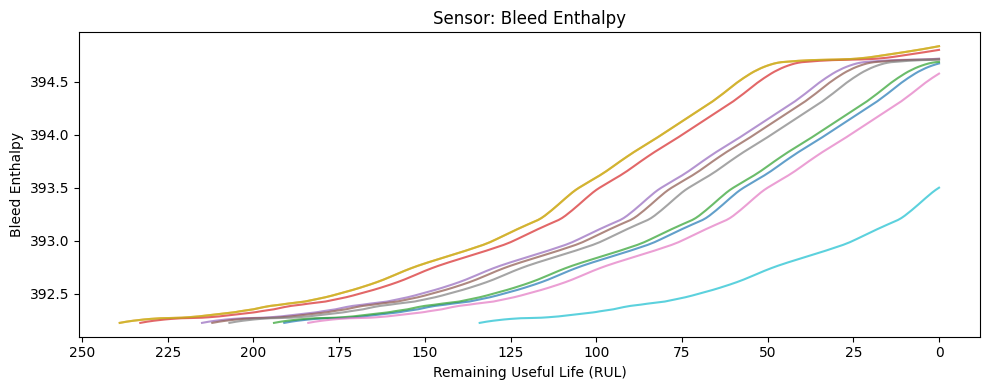

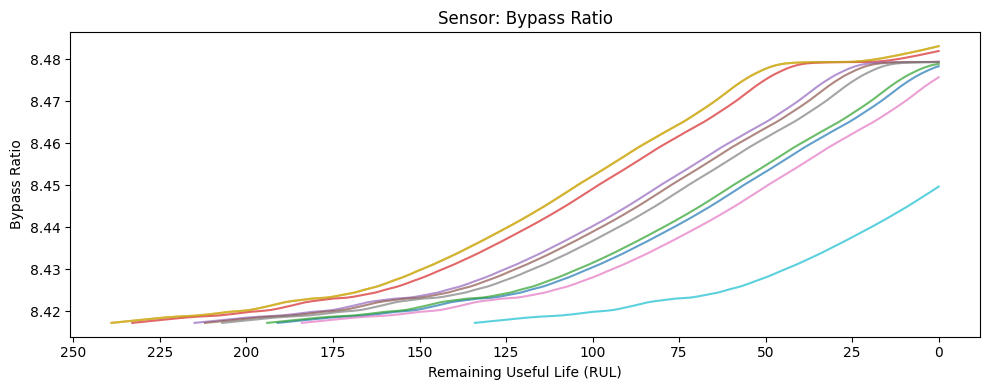

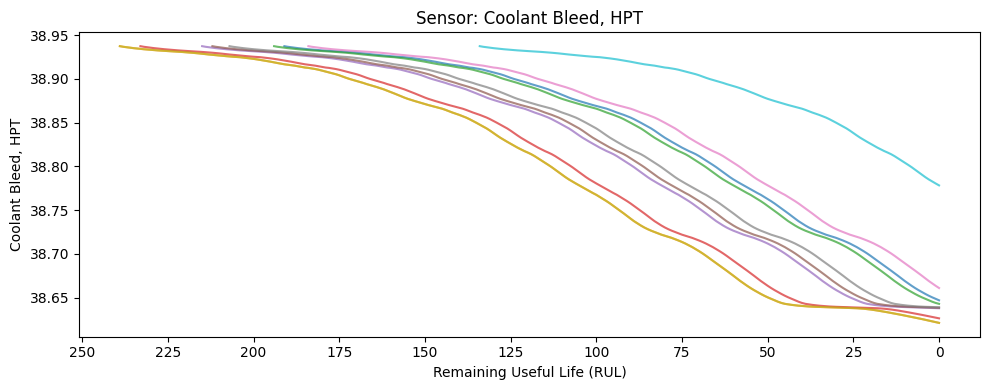

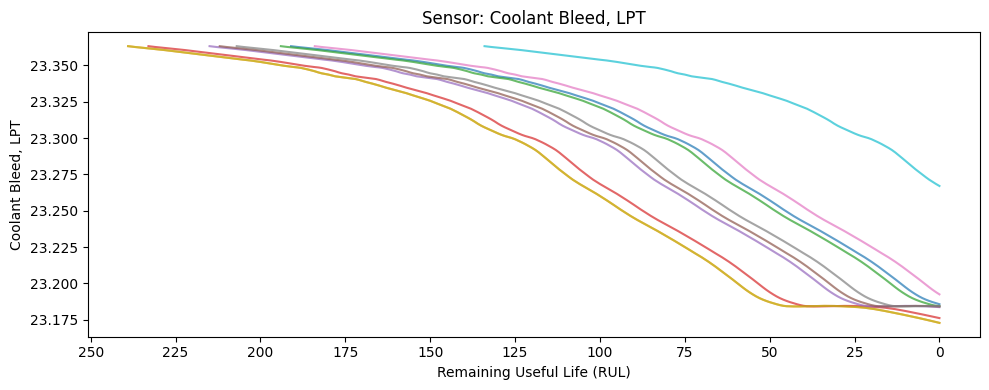

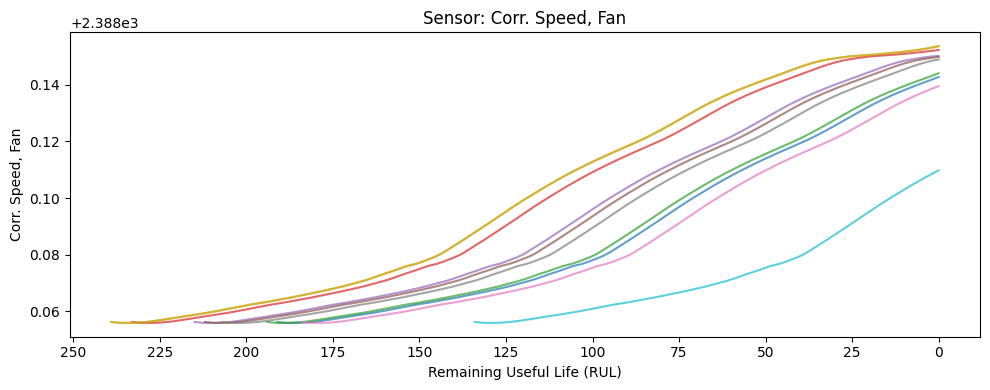

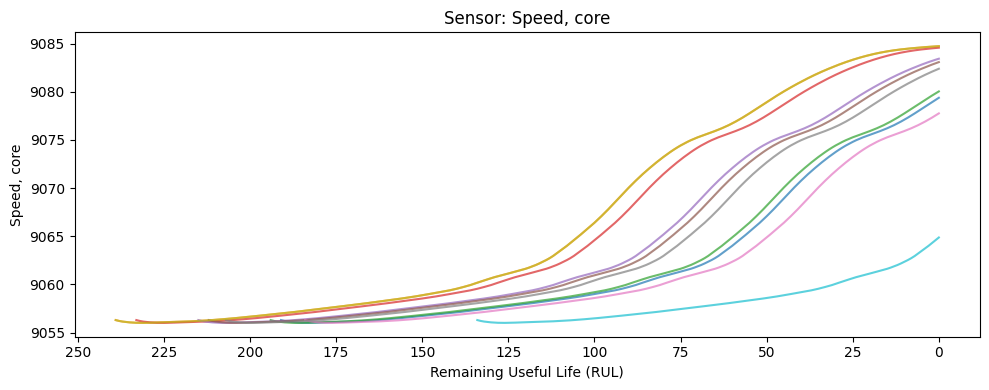

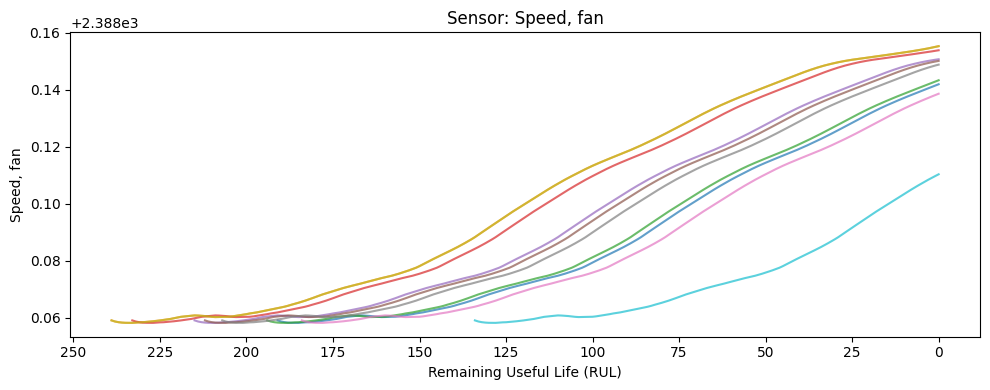

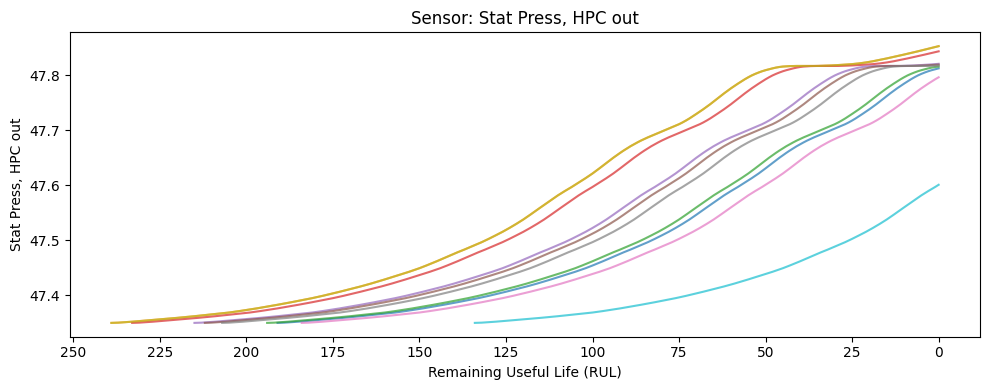

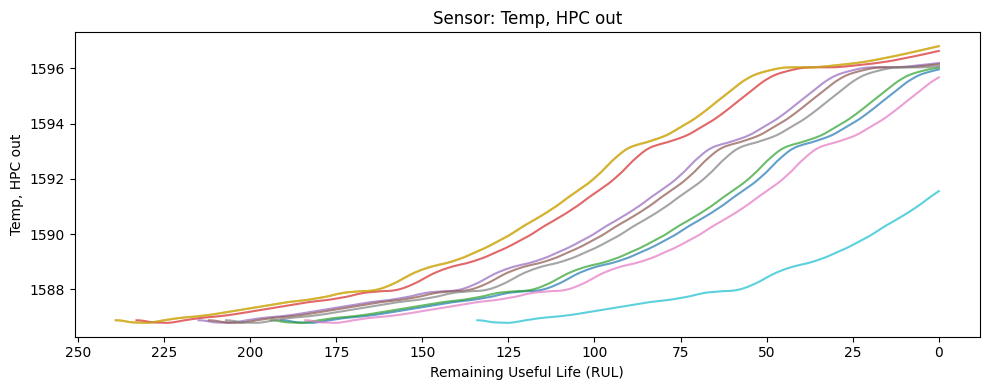

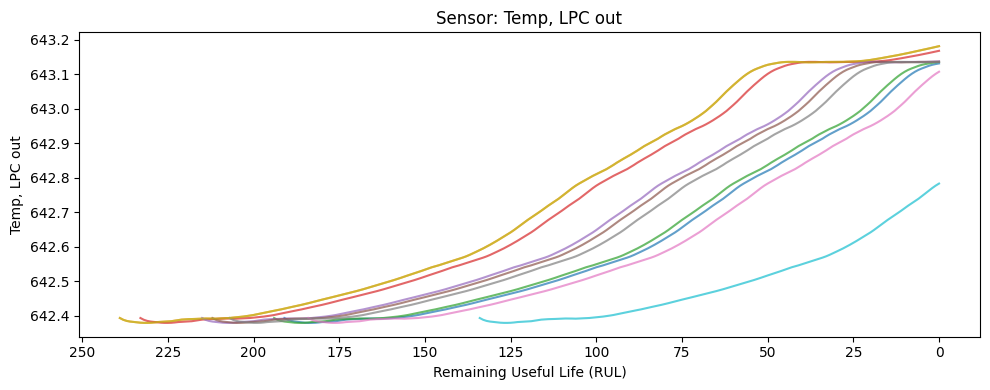

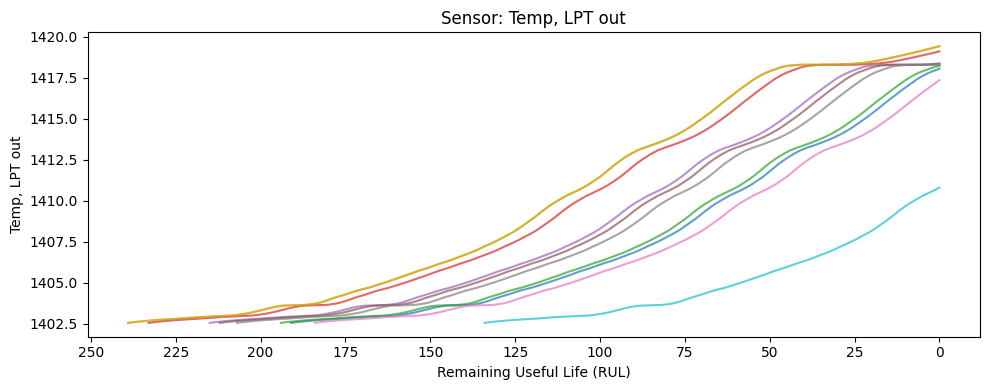

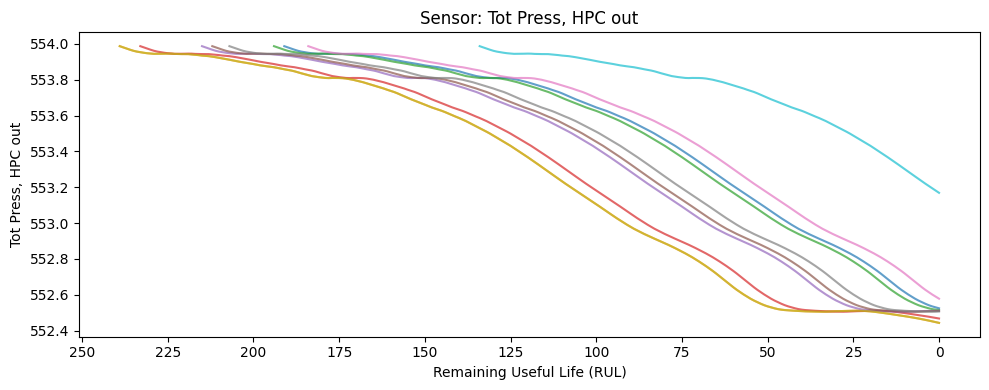

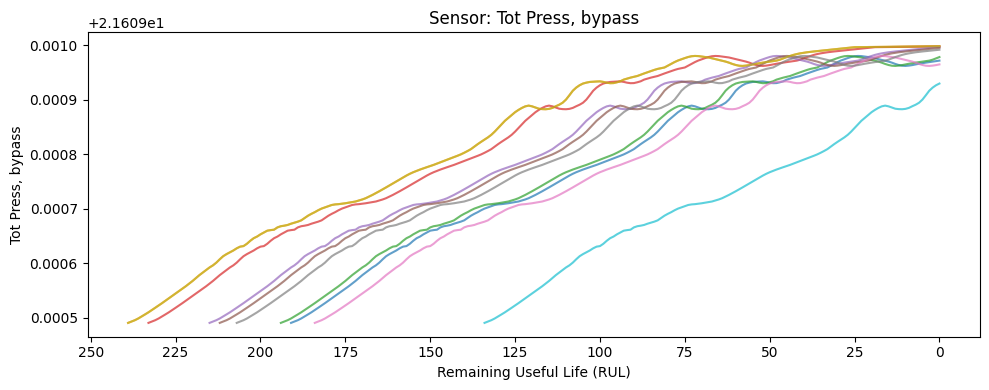

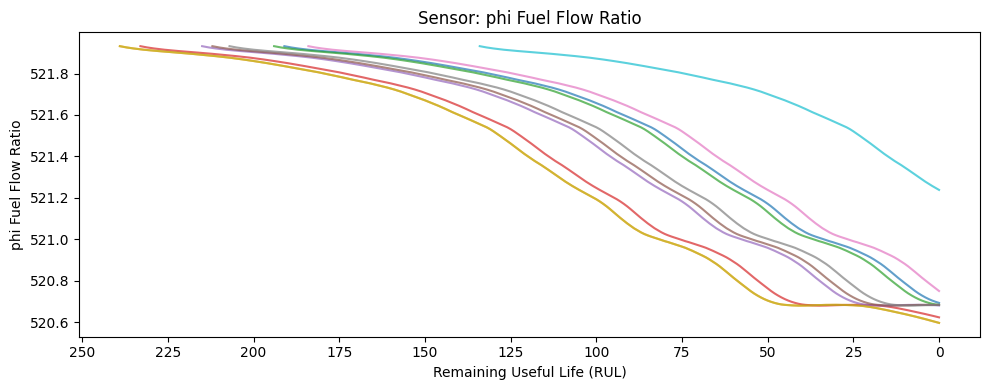

In [29]:
plot_sensors(smoothed_df_train)

## Exponential Smoothing

In [30]:
def exp_smooth(df, alpha=0.5):
    # create a new df to store the smoothed values
    smoothed_df = pd.DataFrame()
    smoothed_df['unit_number'] = df['unit_number']
    smoothed_df['time_cycles'] = df['time_cycles']
    smoothed_df['RUL'] = df['RUL']

    sensor_cols = df.columns.difference(['unit_number', 'RUL', 'time_cycles'])

    # apply exp smoother to each sensor column
    for sensor in sensor_cols:
        smoothed_df[sensor] = df[sensor].ewm(alpha=alpha).mean()

    # return the smoothed smoothed df
    return smoothed_df

# apply to df
smoothed_df = exp_smooth(train, 0.5)

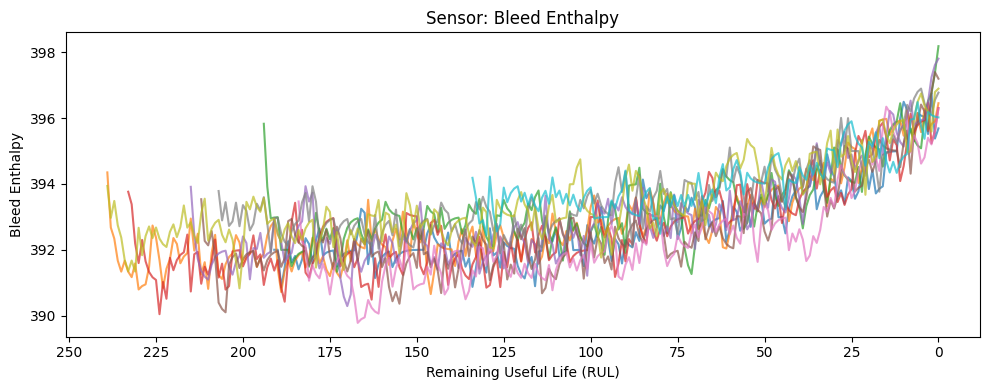

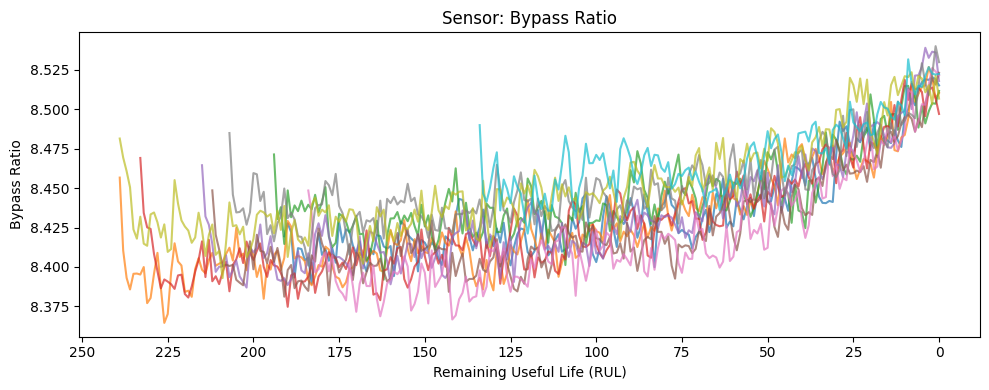

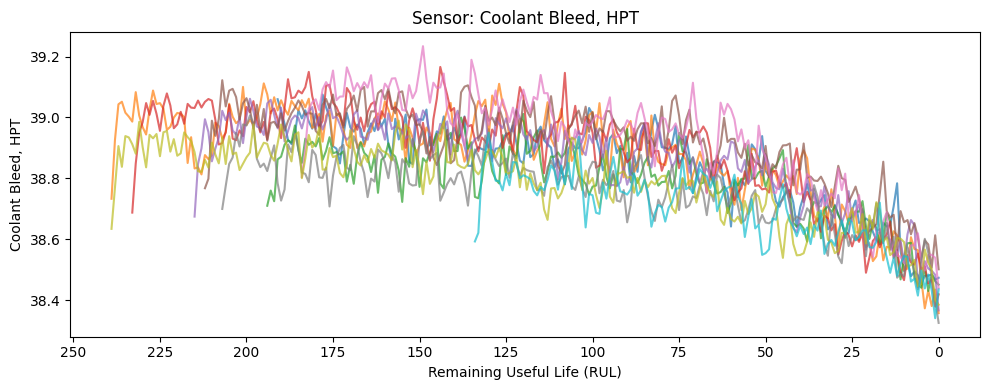

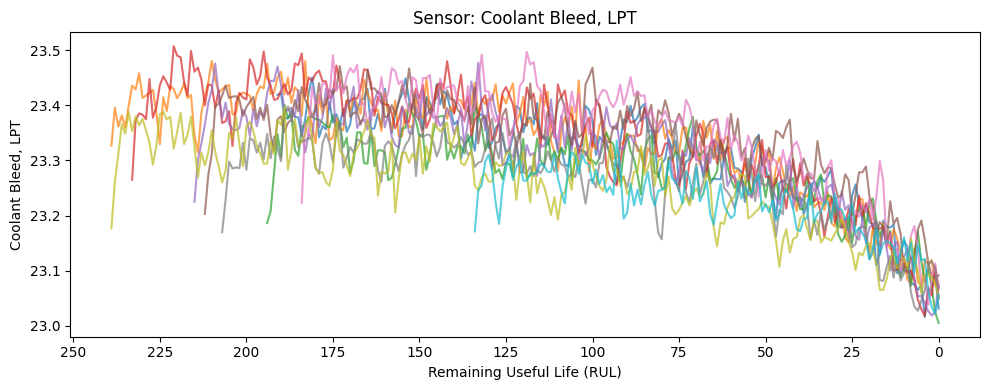

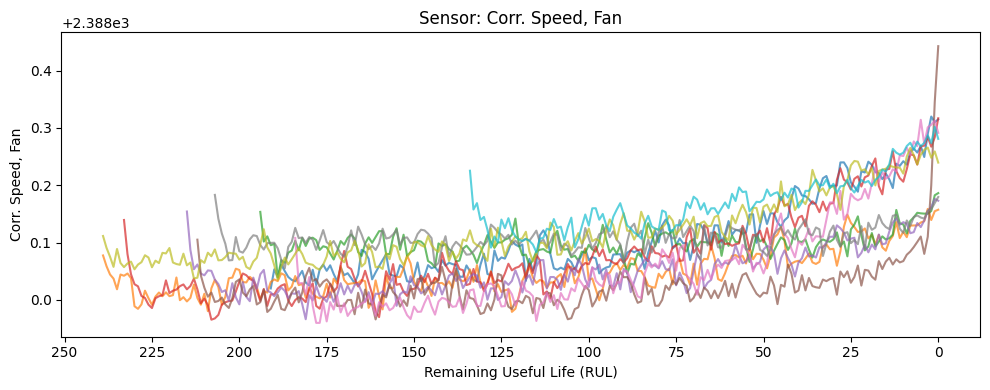

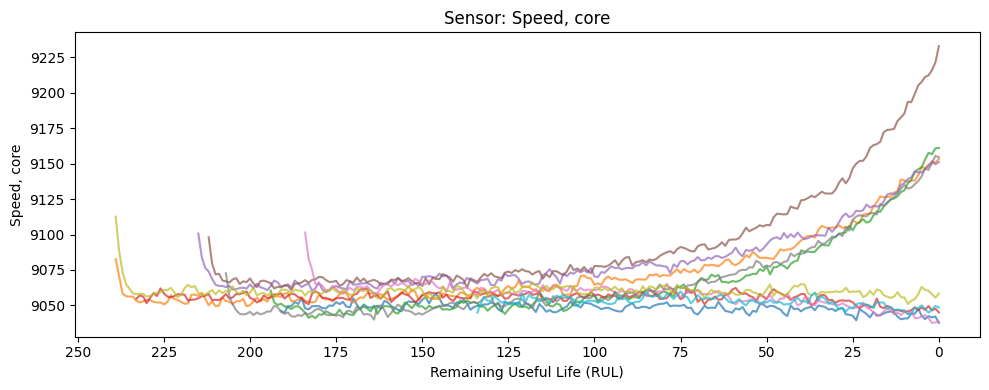

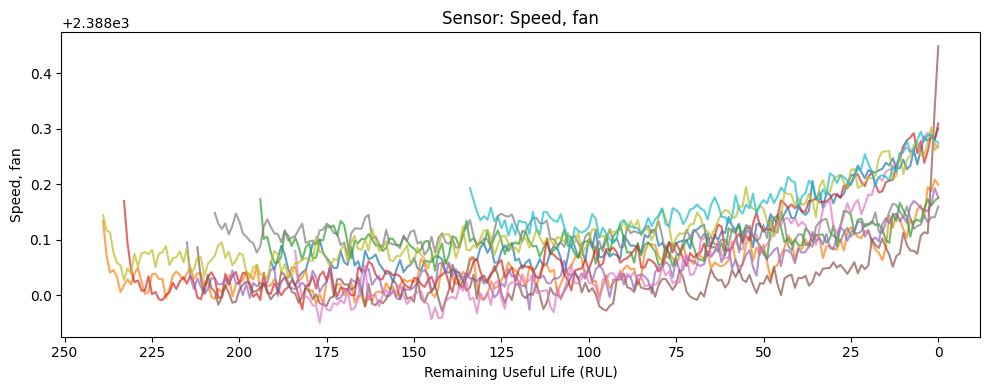

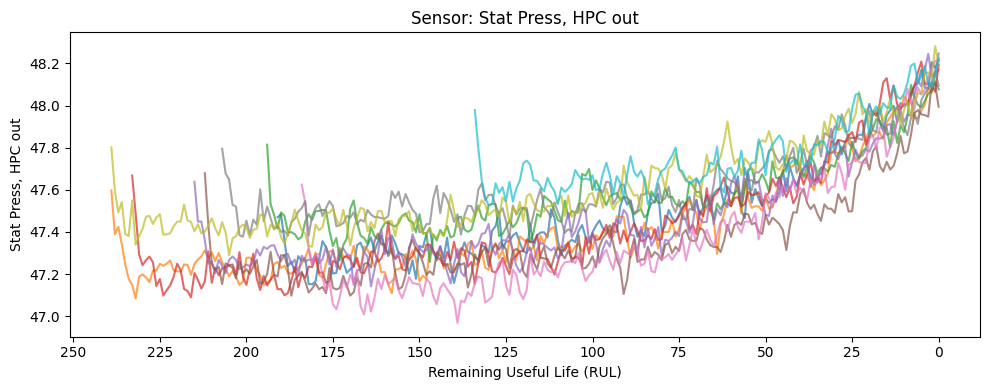

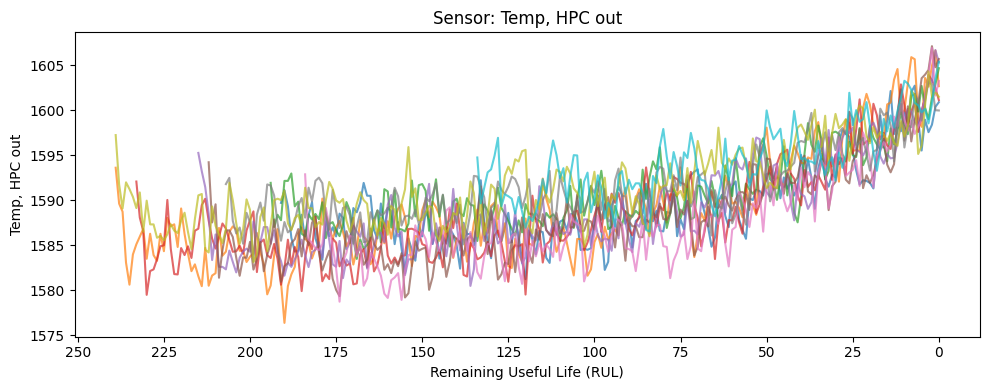

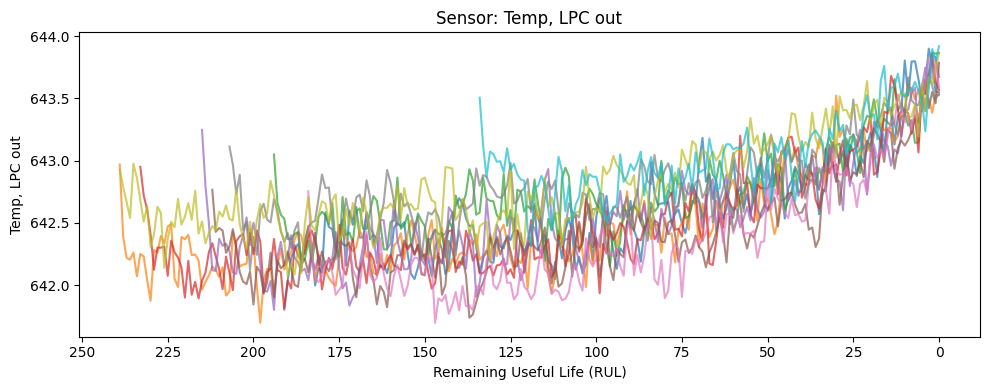

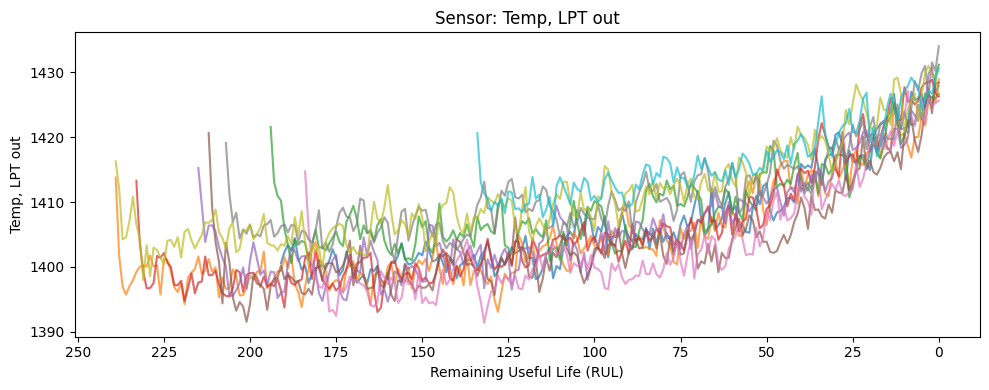

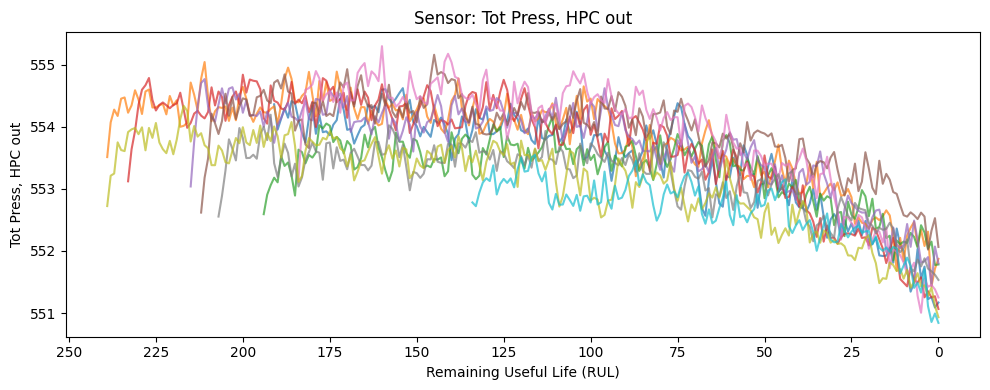

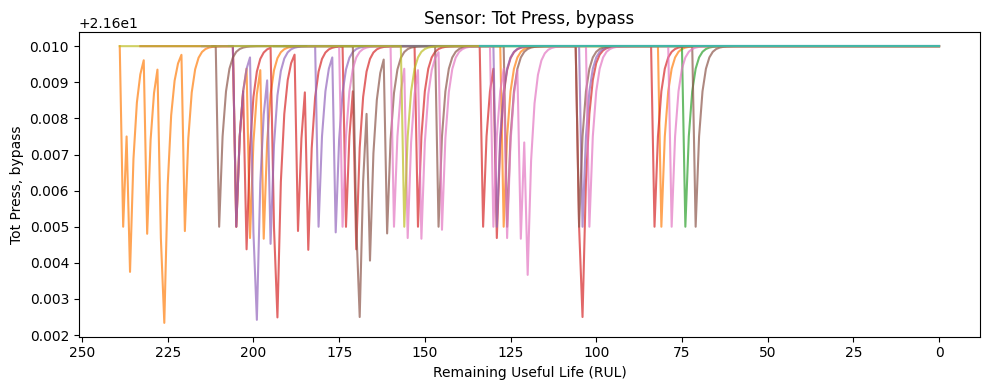

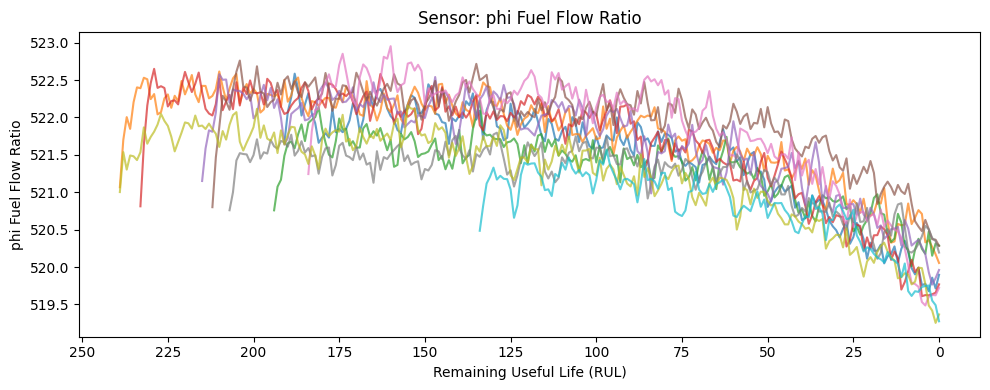

In [31]:
plot_sensors(smoothed_df)